In [9]:
import os
import torch
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download


# Carica il modello ViT UNI (senza classificatore finale, num_classes=0 -> emb)
model = timm.create_model("hf-hub:MahmoodLab/uni", pretrained=True, init_values=1e-5)
model.eval().cuda()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inpl

In [10]:
from torch.utils.data import DataLoader
from src.data.dataset import PatchFromH5Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

IMG_SIZE = 224
dataset = PatchFromH5Dataset(
    h5_dir='/equilibrium/datasets/TCGA-histological-data/hest/patches/patches/',
    transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),])
)

labels = dataset.labels


trainval_idx, test_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.3,
    stratify=dataset.labels,
    random_state=42
)

# Ottieni i label corrispondenti per il secondo split
trainval_labels = [dataset.labels[i] for i in trainval_idx]

# Split: train vs val
train_idx, val_idx = train_test_split(
    trainval_idx,
    test_size=0.3,
    stratify=trainval_labels,
    random_state=42
)

# Crea i subset
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

In [11]:
from torch.utils.data import WeightedRandomSampler

def make_sampler(subset):
    labels_subset = [dataset.labels[i] for i in subset.indices]
    class_sample_count = np.bincount(labels_subset)
    weights = 1.0 / class_sample_count[labels_subset]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_sampler = make_sampler(train_dataset)
val_sampler   = make_sampler(val_dataset)
test_sampler  = make_sampler(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=64,  num_workers=16, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=64,  num_workers=16, drop_last=True, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=16, drop_last=True, sampler=test_sampler)

In [ ]:
def extract_embeddings(dataloader, model, device="cuda"):
    all_embeddings, all_labels = [], []
    with torch.inference_mode():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            feats = model(imgs)  # [B, 1024]
            all_embeddings.append(feats.cpu())
            all_labels.append(labels)
    return torch.cat(all_embeddings), torch.cat(all_labels)

train_emb, train_labels = extract_embeddings(train_loader, model)
val_emb,   val_labels   = extract_embeddings(val_loader, model)
test_emb,  test_labels  = extract_embeddings(test_loader, model)


In [ ]:
import torch.nn.functional as F

# Centroidi per ogni classe dal train set
num_classes = len(dataset.class_names)
centroids = []
for c in range(num_classes):
    mask = (train_labels == c)
    if mask.sum() > 0:
        centroids.append(train_emb[mask].mean(0, keepdim=True))
    else:
        centroids.append(torch.zeros((1, train_emb.size(1))))
centroids = torch.cat(centroids)

# Classificazione su test set
with torch.inference_mode():
    sims = F.cosine_similarity(test_emb.unsqueeze(1), centroids.unsqueeze(0), dim=-1)  # [N_test, num_classes]
    preds = sims.argmax(dim=-1)

from sklearn.metrics import classification_report
print(classification_report(test_labels, preds, target_names=dataset.class_names))


              precision    recall  f1-score   support

     Healthy       0.04      0.01      0.02       354
        SKCM       0.00      0.00      0.00       354
        PRAD       0.16      0.26      0.20       353
        COAD       0.38      0.24      0.29       353
         MEL       0.26      0.41      0.32       354
       HGSOC       0.17      0.15      0.16       352
        LUAD       0.29      0.27      0.28       354
        PAAD       0.08      0.07      0.07       354
    COADREAD       0.21      0.21      0.21       354
         GBM       0.01      0.01      0.01       352
         ALL       0.35      0.13      0.19       353
         HCC       0.20      0.14      0.16       354
        PRCC       0.29      0.58      0.38       353
         IDC       0.07      0.06      0.07       353
         ILC       0.37      0.13      0.19       355
        LNET       0.51      0.80      0.62       351
        LUSC       0.29      0.64      0.40       352
         SOC       0.38    

/tmp/ipykernel_316910/2709671900.py:9: UserWarning: Mismatched number of handles and labels: len(handles) = 9 len(labels) = 27
  plt.legend(handles=scatter.legend_elements()[0], labels=dataset.class_names, bbox_to_anchor=(1.05, 1), loc='upper left')


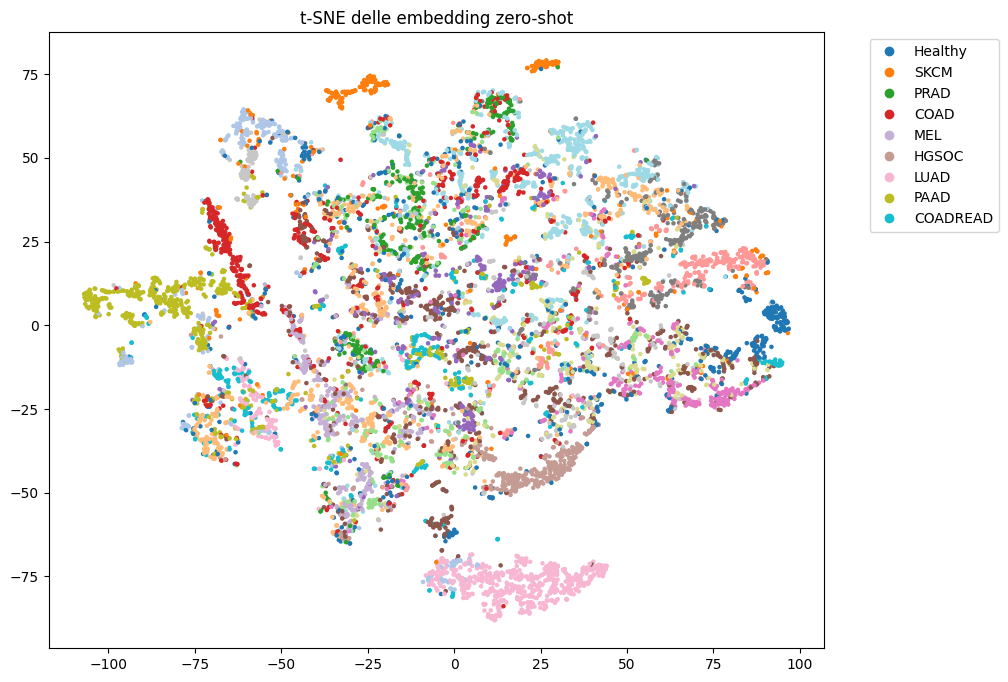

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, init="random", random_state=42)
emb_2d = tsne.fit_transform(test_emb.numpy())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=test_labels.numpy(), cmap="tab20", s=5)
plt.legend(handles=scatter.legend_elements()[0], labels=dataset.class_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE delle embedding zero-shot")
plt.show()
